In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation

In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
default_structure_ids

[315, 698, 1089, 703, 477, 803, 549, 1097, 313, 771, 354, 512]

In [4]:
connectivity_data = get_connectivity_data(cache, major_structure_ids[:12], experiments_exclude, remove_injection = False)

connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()


512
703
1089
1097
315
313
354
698
771
803
477
549


In [ ]:
connectivity_data.

In [8]:
connectivity_data.get_data_matrices(default_structure_ids)

In [13]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)

#contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
#ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order_leaves)[np.isin(ontological_order_leaves, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [16]:
connectivity_data.get_crelines(data_info)

In [17]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [18]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)
def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

In [25]:
from mcmodels.core import Mask

def get_connectivity_matrices(connectivity_data, cres, structure_dict, source_ordering, target_ordering, structure_major_dictionary,gamma_dict = None):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(cres)
    
    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions     
                                                      
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        #print(iy)
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)   
    
    #reorder = np.concatenate([ipsi_indices, contra_indices])  
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction(cache, connectivity_data.structure_datas[sid], structures = structure_dict[sid], prediction_region=source_ordering[i], cre = cres[c], gamma = gamma, surface = connectivity_data.structure_datas[sid].loss_surface_cv, cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction(cache, structure_data,  structures, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    leaf_experiments = np.where(structures == prediction_region)[0]
    nexp = len(leaf_experiments)
    centroids = structure_data.centroids[leaf_experiments]
    cres = structure_data.crelines[leaf_experiments]
    projections = structure_data.reg_proj_norm[leaf_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

    if surface != None and cre_model != True:
        means = get_means(projections,cres, np.repeat(prediction_region,nexp))
        
        losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
        predictions = get_nw_predictions(projections, losses, gamma)
        output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        means = get_means(projections, cres, np.repeat(prediction_region,nexp))
        #print(means)
        if np.isin(cre, np.asarray(list(means[prediction_region].keys()))):
            losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[prediction_region])
            predictions = get_nw_predictions(projections, losses, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
            
    if surface == None and cre_model != True:
        means = get_means(projections, cres, [prediction_region])
        predictions = means[cres]
        output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
        output = np.mean(predictions, axis = 0)
        
    
    return(output)


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)


def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

    
def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


In [22]:
#wrong dist (not remove)... try to recreate old result
frac_learn = np.ones(12)
frac_learn[4] = .1
sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 10
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[4] = 20000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 10
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 1000
gammas_surface[11] = 1000

for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                 connectivity_data.creline[sid],connectivity_data.leafs[sid],
                                                                                 frac_learn[m],
                                                                                 gamma = gammas_surface[m])

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<IPython.core.display.Javascript object>


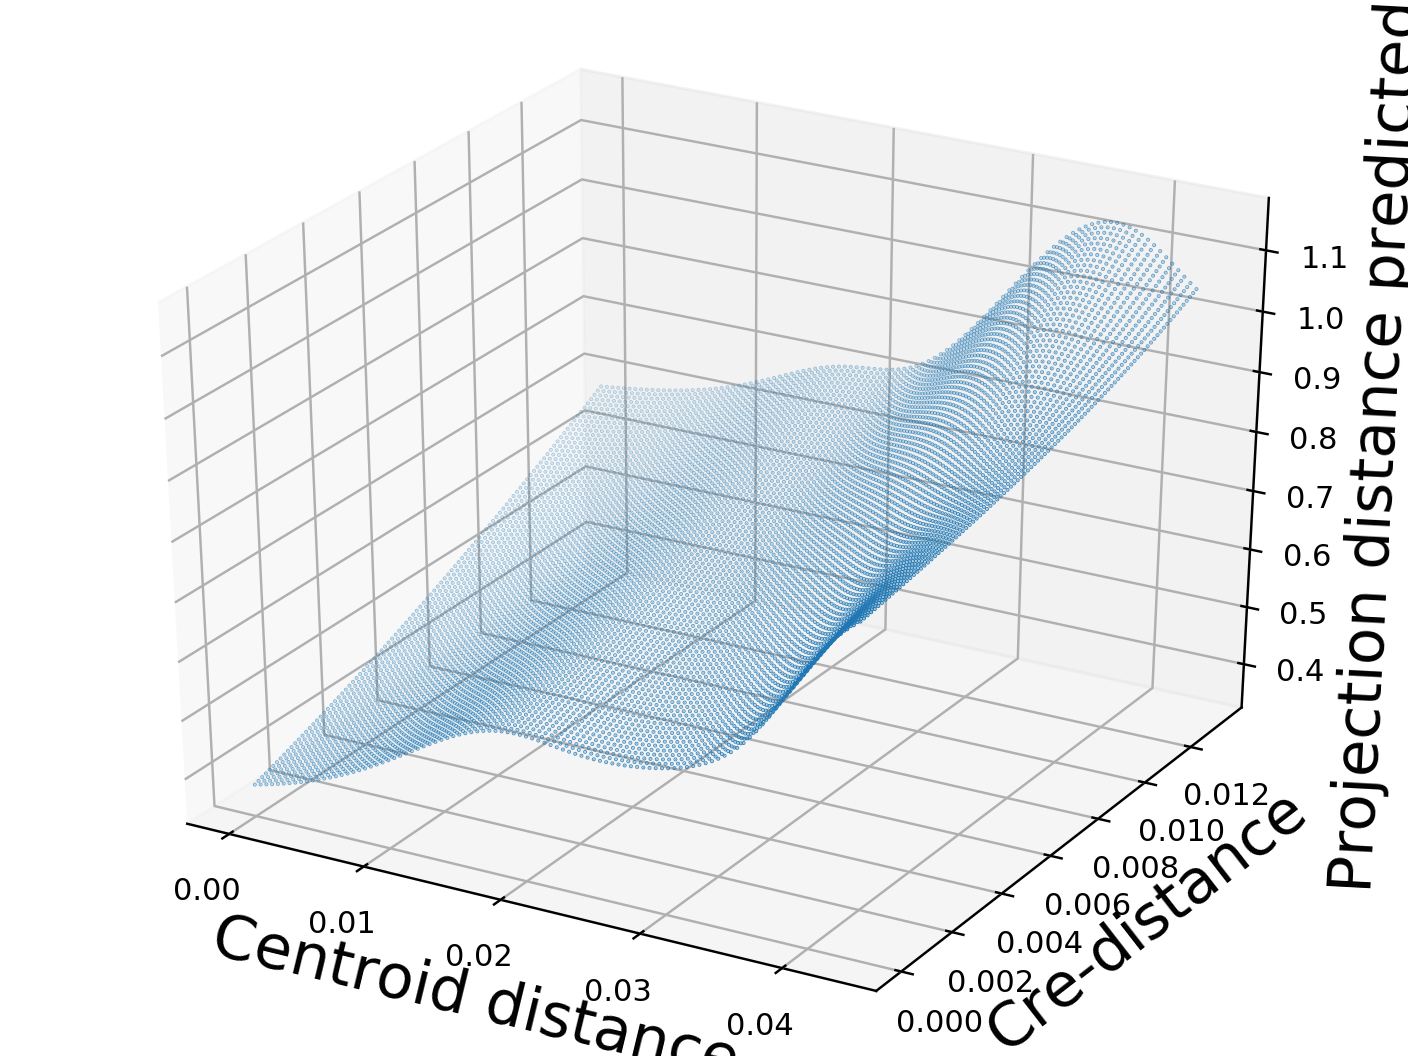

In [23]:
%matplotlib notebook
plot_loss_surface(connectivity_data.structure_datas[major_structure_ids[4]].loss_surface_cv)
#plt.savefig('/Users/samsonkoelle/isocortexsurface')

In [26]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

In [29]:
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)


In [30]:
gammas = np.asarray([0.1,.5,1,2,10,20,40])
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
a= [list(range(7))]
keys = np.asarray(list(itertools.product(*a)))

reg_proj_norm= {}
nwloocv_leaf_leaf2 = {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    nwloocv_leaf_leaf2[sid] = connectivity_data.structure_datas[sid].loocv_predictions_leaf_leaf2


losses_leaf_leaf2 = get_loss(reg_proj_norm, nwloocv_leaf_leaf2,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2_2stage = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
e [ 0 12 16] m [ 0 12 16]
m 0 3 0.0020073974 nan
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
e [ 6 28] m [ 6 28]
m 1 2 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.0020073974 nan
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
e [ 9 19] m [ 9 19]
m 5 2 0.0020073974 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0020073974 nan
e [ 5  7 14 15 30 31] m [ 5  7 14 15 30 31]
e [ 5  7 14 15 30 31] m [ 5  7 14 15 30 31]
e [ 5  7 

e [  7  10  16  31  36  57  85 110] m [  7  10  16  31  36  57  85 110]
m 9 8 0.0030163364 0.003439033478606974
e [ 27  54  72  73  77  78  89 117 121] m [ 27  54  72  73  77  78  89 117 121]
e [ 27  54  72  73  77  78  89 117 121] m [ 27  54  72  73  77  78  89 117 121]
e [ 27  54  72  73  77  78  89 117 121] m [ 27  54  72  73  77  78  89 117 121]
e [ 27  54  72  73  77  78  89 117 121] m [ 27  54  72  73  77  78  89 117 121]
e [ 27  54  72  73  77  78  89 117 121] m [ 27  54  72  73  77  78  89 117 121]
e [ 27  54  72  73  77  78  89 117 121] m [ 27  54  72  73  77  78  89 117 121]
e [ 27  54  72  73  77  78  89 117 121] m [ 27  54  72  73  77  78  89 117 121]
m 10 9 0.0030163364 0.004155711993977582
e [ 6 21 43 83 90] m [ 6 21 43 83 90]
e [ 6 21 43 83 90] m [ 6 21 43 83 90]
e [ 6 21 43 83 90] m [ 6 21 43 83 90]
e [ 6 21 43 83 90] m [ 6 21 43 83 90]
e [ 6 21 43 83 90] m [ 6 21 43 83 90]
e [ 6 21 43 83 90] m [ 6 21 43 83 90]
e [ 6 21 43 83 90] m [ 6 21 43 83 90]
m 11 5 0.0030163364 0

m 1 6 0.004280918 0.0037773688088994007
e [ 66 465] m [ 66 465]
e [ 66 465] m [ 66 465]
e [ 66 465] m [ 66 465]
e [ 66 465] m [ 66 465]
e [ 66 465] m [ 66 465]
e [ 66 465] m [ 66 465]
e [ 66 465] m [ 66 465]
m 2 2 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 3 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 4 0 0.004280918 nan
e [ 28 386 529 854 890] m [ 28 386 529 854 890]
e [ 28 386 529 854 890] m [ 28 386 529 854 890]
e [ 28 386 529 854 890] m [ 28 386 529 854 890]
e [ 28 386 529 854 890] m [ 28 386 529 854 890]
e [ 28 386 529 854 890] m [ 28 386 529 854 890]
e [ 28 386 529 854 890] m [ 28 386 529 854 890]
e [ 28 386 529 854 890] m [ 28 386 529 854 890]
m 5 5 0.004280918 0.0038452210545609606
e [182 304 415 520 688 868] m [182 304 415 520 688 868]
e [182 304 415 520 688 868] m [182 304 415 520 688 868]
e [182 304 415 520 688 868] m [182 304 415 520 688 868]
e [182 304 415 520 688 868] m [182 304 415

e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 26 0 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 27 0 0.004280918 nan
e [ 425  775 1035] m [ 425  775 1035]
e [ 425  775 1035] m [ 425  775 1035]
e [ 425  775 1035] m [ 425  775 1035]
e [ 425  775 1035] m [ 425  775 1035]
e [ 425  775 1035] m [ 425  775 1035]
e [ 425  775 1035] m [ 425  775 1035]
e [ 425  775 1035] m [ 425  775 1035]
m 28 3 0.004280918 0.0032740101722128624
e [240 809] m [240 809]
e [240 809] m [240 809]
e [240 809] m [240 809]
e [240 809] m [240 809]
e [240 809] m [240 809]
e [240 809] m [240 809]
e [240 809] m [240 809]
m 29 2 0.004280918 nan
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
e [560 708] m [560 708]
m 30 2 0.004280918 0.004090929550722706
e [ 38 391] m [ 38 391]
e [ 38 391] m [ 38 391]
e [ 38 391] m [ 38 391]
e [ 38 391] m [ 38 391]
e [ 38 391] m [ 38 391

e [  22   65   81  113  156  451  503  640  702  784  916 1032 1065] m [  22   65   81  113  156  451  503  640  702  784  916 1032 1065]
e [  22   65   81  113  156  451  503  640  702  784  916 1032 1065] m [  22   65   81  113  156  451  503  640  702  784  916 1032 1065]
e [  22   65   81  113  156  451  503  640  702  784  916 1032 1065] m [  22   65   81  113  156  451  503  640  702  784  916 1032 1065]
e [  22   65   81  113  156  451  503  640  702  784  916 1032 1065] m [  22   65   81  113  156  451  503  640  702  784  916 1032 1065]
e [  22   65   81  113  156  451  503  640  702  784  916 1032 1065] m [  22   65   81  113  156  451  503  640  702  784  916 1032 1065]
e [  22   65   81  113  156  451  503  640  702  784  916 1032 1065] m [  22   65   81  113  156  451  503  640  702  784  916 1032 1065]
m 43 13 0.004280918 0.00441707015468043
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 44 0 0.004280918 nan
e [ 131  175  206  223  272  331  355  

m 54 75 0.004280918 0.0039061802592684543
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 55 0 0.004280918 nan
e [   2   10   15   25   30   34   43   61   64   67  104  129  133  138
  143  161  163  170  193  198  225  232  241  258  259  267  287  327
  337  366  379  383  389  424  433  438  442  443  445  448  494  501
  505  526  531  536  571  574  590  594  608  609  612  620  627  636
  646  651  663  665  670  695  701  704  724  730  743  792  794  840
  841  880  881  885  886  900  908  927  928  939  942  950  951  954
  967  970  998 1007 1011 1023 1038 1069 1081 1087 1091 1107 1116 1123
 1124 1127] m [   2   10   15   25   30   34   43   61   64   67  104  129  133  138
  143  161  163  170  193  198  225  232  241  258  259  267  287  327
  337  366  379  383  389  424  433  438  442  443  445  448  494  501
  505  526  531  536  571  574  590  594  608  609  612  620  627  636
  646  651  663  665  670  695  701  704  724  730  743  792  794  8

e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019]
e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019]
e [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
  912  949  988 1005 1019] m [  24   63  115  120  127  134  142  168  212  253  301  363  368  375
  396  470  491  559  653  656  661  681  751  770  777  789  896  906
 

e [  21   51   74   75   87   93   97  101  108  117  121  125  145  164
  178  197  199  201  207  208  210  214  216  221  222  227  231  246
  249  250  262  268  269  270  291  300  306  311  315  317  326  328
  335  336  346  347  348  349  351  358  374  394  397  407  444  459
  476  493  506  511  513  550  578  582  584  593  602  607  641  669
  696  703  709  717  722  727  740  748  762  765  771  778  780  798
  802  804  806  818  819  829  830  835  836  849  887  897  901  910
  918  919  924  929  931  932  934  945  962  971  980  983  984  999
 1040 1043 1060 1063 1067 1071 1080 1090 1096 1097 1102 1106] m [  21   51   74   75   87   93   97  101  108  117  121  125  145  164
  178  197  199  201  207  208  210  214  216  221  222  227  231  246
  249  250  262  268  269  270  291  300  306  311  315  317  326  328
  335  336  346  347  348  349  351  358  374  394  397  407  444  459
  476  493  506  511  513  550  578  582  584  593  602  607  641  669
  696  703 

m 71 10 0.004280918 0.003611411146242015
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
e [ 14  35 292 428 714 968] m [ 14  35 292 428 714 968]
m 72 6 0.004280918 0.0034974082349239445
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
e [265 367 402 455 628 737 958 981] m [265 367 402 455 628 737 958 981]
m 73 8 0.004280918 0.0

m 84 12 0.004280918 0.003655171520763679
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 85 0 0.004280918 nan
e [576 909 966] m [576 909 966]
e [576 909 966] m [576 909 966]
e [576 909 966] m [576 909 966]
e [576 909 966] m [576 909 966]
e [576 909 966] m [576 909 966]
e [576 909 966] m [576 909 966]
e [576 909 966] m [576 909 966]
m 86 3 0.004280918 nan
e [  73   86  149  256  307  604  914 1117] m [  73   86  149  256  307  604  914 1117]
e [  73   86  149  256  307  604  914 1117] m [  73   86  149  256  307  604  914 1117]
e [  73   86  149  256  307  604  914 1117] m [  73   86  149  256  307  604  914 1117]
e [  73   86  149  256  307  604  914 1117] m [  73   86  149  256  307  604  914 1117]
e [  73   86  149  256  307  604  914 1117] m [  73   86  149  256  307  604  914 1117]
e [  73   86  149  256  307  604  914 1117] m [  73   86  149  256  307  604  914 1117]
e [  73   86  149  256  307  604  914 1117] m [  73   86  149  256  307  604  914 1117]
m 8

e [  3  48  79 109 146 203 286 338 618 673 749 776] m [  3  48  79 109 146 203 286 338 618 673 749 776]
e [  3  48  79 109 146 203 286 338 618 673 749 776] m [  3  48  79 109 146 203 286 338 618 673 749 776]
e [  3  48  79 109 146 203 286 338 618 673 749 776] m [  3  48  79 109 146 203 286 338 618 673 749 776]
e [  3  48  79 109 146 203 286 338 618 673 749 776] m [  3  48  79 109 146 203 286 338 618 673 749 776]
e [  3  48  79 109 146 203 286 338 618 673 749 776] m [  3  48  79 109 146 203 286 338 618 673 749 776]
m 97 12 0.004280918 0.004686444389535255
e [251 752] m [251 752]
e [251 752] m [251 752]
e [251 752] m [251 752]
e [251 752] m [251 752]
e [251 752] m [251 752]
e [251 752] m [251 752]
e [251 752] m [251 752]
m 98 2 0.004280918 nan
e [ 290  314  464  585  691  761  795 1109] m [ 290  314  464  585  691  761  795 1109]
e [ 290  314  464  585  691  761  795 1109] m [ 290  314  464  585  691  761  795 1109]
e [ 290  314  464  585  691  761  795 1109] m [ 290  314  464  585  691 

m 116 9 0.004280918 0.00382459381312667
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
e [399 965] m [399 965]
m 117 2 0.004280918 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 118 0 0.004280918 nan
(119, 7, 1128, 1077)
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
e [ 2 58 61] m [ 2 58 61]
m 0 3 0.0044946857 0.0034176578477212774
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
e [14 49 64] m [14 49 64]
m 1 3 0.0044946857 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 2 0 0.0044946857 nan
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m [12 32]
e [12 32] m 

e [11 21 23] m [11 21 23]
e [11 21 23] m [11 21 23]
e [11 21 23] m [11 21 23]
e [11 21 23] m [11 21 23]
m 5 3 0.0049728127 0.004028222132764859
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 6 0 0.0049728127 nan
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
e [ 0 29] m [ 0 29]
m 7 2 0.0049728127 nan
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
e [ 3 22] m [ 3 22]
m 8 2 0.0049728127 nan
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
e [ 9 27] m [ 9 27]
m 9 2 0.0049728127 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 10 0 0.0049728127 nan
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
e [28 32] m [28 32]
m 11 2 0.0049728127 0.003059716363098103

e [ 8 26 35] m [ 8 26 35]
m 21 3 0.003704043 0.0045359958701663376
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 22 0 0.003704043 nan
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
e [34 55] m [34 55]
m 23 2 0.003704043 nan
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
e [11 39 40] m [11 39 40]
m 24 3 0.003704043 nan
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
e [] m []
m 25 0 0.003704043 nan
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
e [18 32 42 54 62 67] m [18 32 42 54 62 67]
m 26 6 0.003704043 0.0029571522883963123
e [27 59 71] m [27 59 71]
e [2

In [34]:

    def get_leaf_major_dictionary(connectivity_data):
        #connectivity_data = self
        structure_major_dictionary = {}
        keys = np.asarray(list(connectivity_data.structure_datas))
        for sid in keys:
            strs_sid = np.unique(connectivity_data.leafs[sid])
            nstrs = len(strs_sid)
            for s in range(nstrs):
                structure_major_dictionary[strs_sid[s]] = sid#connectivity_data.leafs[sid]
        leaf_major_dictionary = structure_major_dictionary
        return(leaf_major_dictionary)

In [36]:
#connectivity_data.get_summarystructure_major_dictionary()
#connectivity_data.summarystructure_major_dictionary = get_summarystructure_major_dictionary(connectivity_data)
#connectivity_data.get_major_summarystructure_dictionary()
connectivity_data.leaf_major_dictionary = get_leaf_major_dictionary(connectivity_data)
#connectivity_data.get_leaf_major_dictionary()
connectivity_data.get_major_leaf_dictionary()
#connectivity_data.major_summarystructure_dictionary = get_major_summarystructure_dictionary(connectivity_data)
#connectivity_data.leaf_major_dictionary = get_leaf_major_dictionary(connectivity_data)
#connectivity_data.major_leaf_dictionary = get_major_leaf_dictionary(connectivity_data)

crelist = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']##
ool = np.asarray(ontological_order_leaves, dtype = int)
#we were not including leafs with no injection
#they could still not have an injection in a given cre...
#they should still be included
indis_2 =np.where(np.isin(ool,np.asarray(list(connectivity_data.leaf_major_dictionary.keys()))))[0]
ools = ool[indis_2]


In [47]:
gamma_dict = {}
for i in range(12):
    gamma_dict[major_structure_ids[i]] = gammas[best_gamma_leaf_leaf2[i,0]]
    
for sid in major_structure_ids:
    
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]

In [48]:
connectivity_matrices = get_connectivity_matrices(connectivity_data, crelist, structure_dict = leafs,
                                                  source_ordering = ools,
                                                  target_ordering= np.asarray(ontological_order_leaves, dtype = int), structure_major_dictionary = connectivity_data.leaf_major_dictionary, gamma_dict = gamma_dict)

0 667
1 526157192
2 526157196
3 943
4 648
5 844
6 656
7 962
8 767
9 1021
10 654
11 702
12 889
13 201
14 1047
15 1070
16 1038
17 113
18 1094
19 1128
20 478
21 657
22 950
23 974
24 1102
25 854
26 577
27 625
28 1111
29 182305701
30 182305709
31 1035
32 1090
33 862
34 187
35 638
36 1058
37 857
38 600
39 678
40 252
41 156
42 816
43 847
44 954
45 791
46 249
47 1023
48 1114
49 233
50 601
51 1066
52 401
53 433
54 1046
55 973
56 573
57 613
58 74
59 821
60 721
61 778
62 33
63 305
64 902
65 377
66 501
67 565
68 257
69 312782586
70 312782590
71 312782594
72 312782640
73 312782644
74 312782648
75 211
76 1015
77 919
78 296
79 772
80 810
81 304
82 363
83 556
84 827
85 448
86 412
87 630
88 440
89 484
90 582
91 620
92 288
93 1125
94 1101
95 783
96 344
97 314
98 800
99 675
100 774
101 906
102 434
103 610
104 274
105 430
106 687
107 590
108 312782554
109 312782558
110 312782562
111 312782566
112 312782608
113 312782612
114 312782616
115 312782620
116 289
117 729
118 988
119 507
120 188
121 204
122 159
12

158 1031
159 342
160 564
161 596
162 581
163 351
164 629
165 685
166 718
167 733
168 414
169 1072
170 1079
171 496345668
172 496345672
173 218
174 1020
175 255
176 1096
177 1113
178 155
179 59
180 362
181 366
182 149
183 15
184 181
185 599
186 907
187 930
188 262
189 178
190 483
191 186
192 390
193 38
194 223
195 272
196 830
197 126
198 286
199 88
200 210
201 525
202 1
203 515
204 1004
205 63
206 693
207 946
208 194
209 364
210 470
211 614
212 804
213 842
214 834
215 811
216 820
217 828
218 381
219 749
220 128
221 26
222 17
223 10
224 587
225 614454277
226 215
227 634
228 214
229 35
230 1052
231 607344834
232 607344854
233 607344858
234 607344862
235 872
236 612
237 123
238 114
239 898
240 931
241 1093
242 574
243 621
244 679
245 162
246 604
247 146
248 358
249 96
250 101
251 1039
252 642
253 429
254 437
255 653
256 661
257 839
258 1048
259 83
260 136
261 955
262 852
263 978
264 202
265 225
266 773
267 222
268 976
269 984
270 1091
271 951
272 968
273 1007
274 1056
275 1064
276 1025
277

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


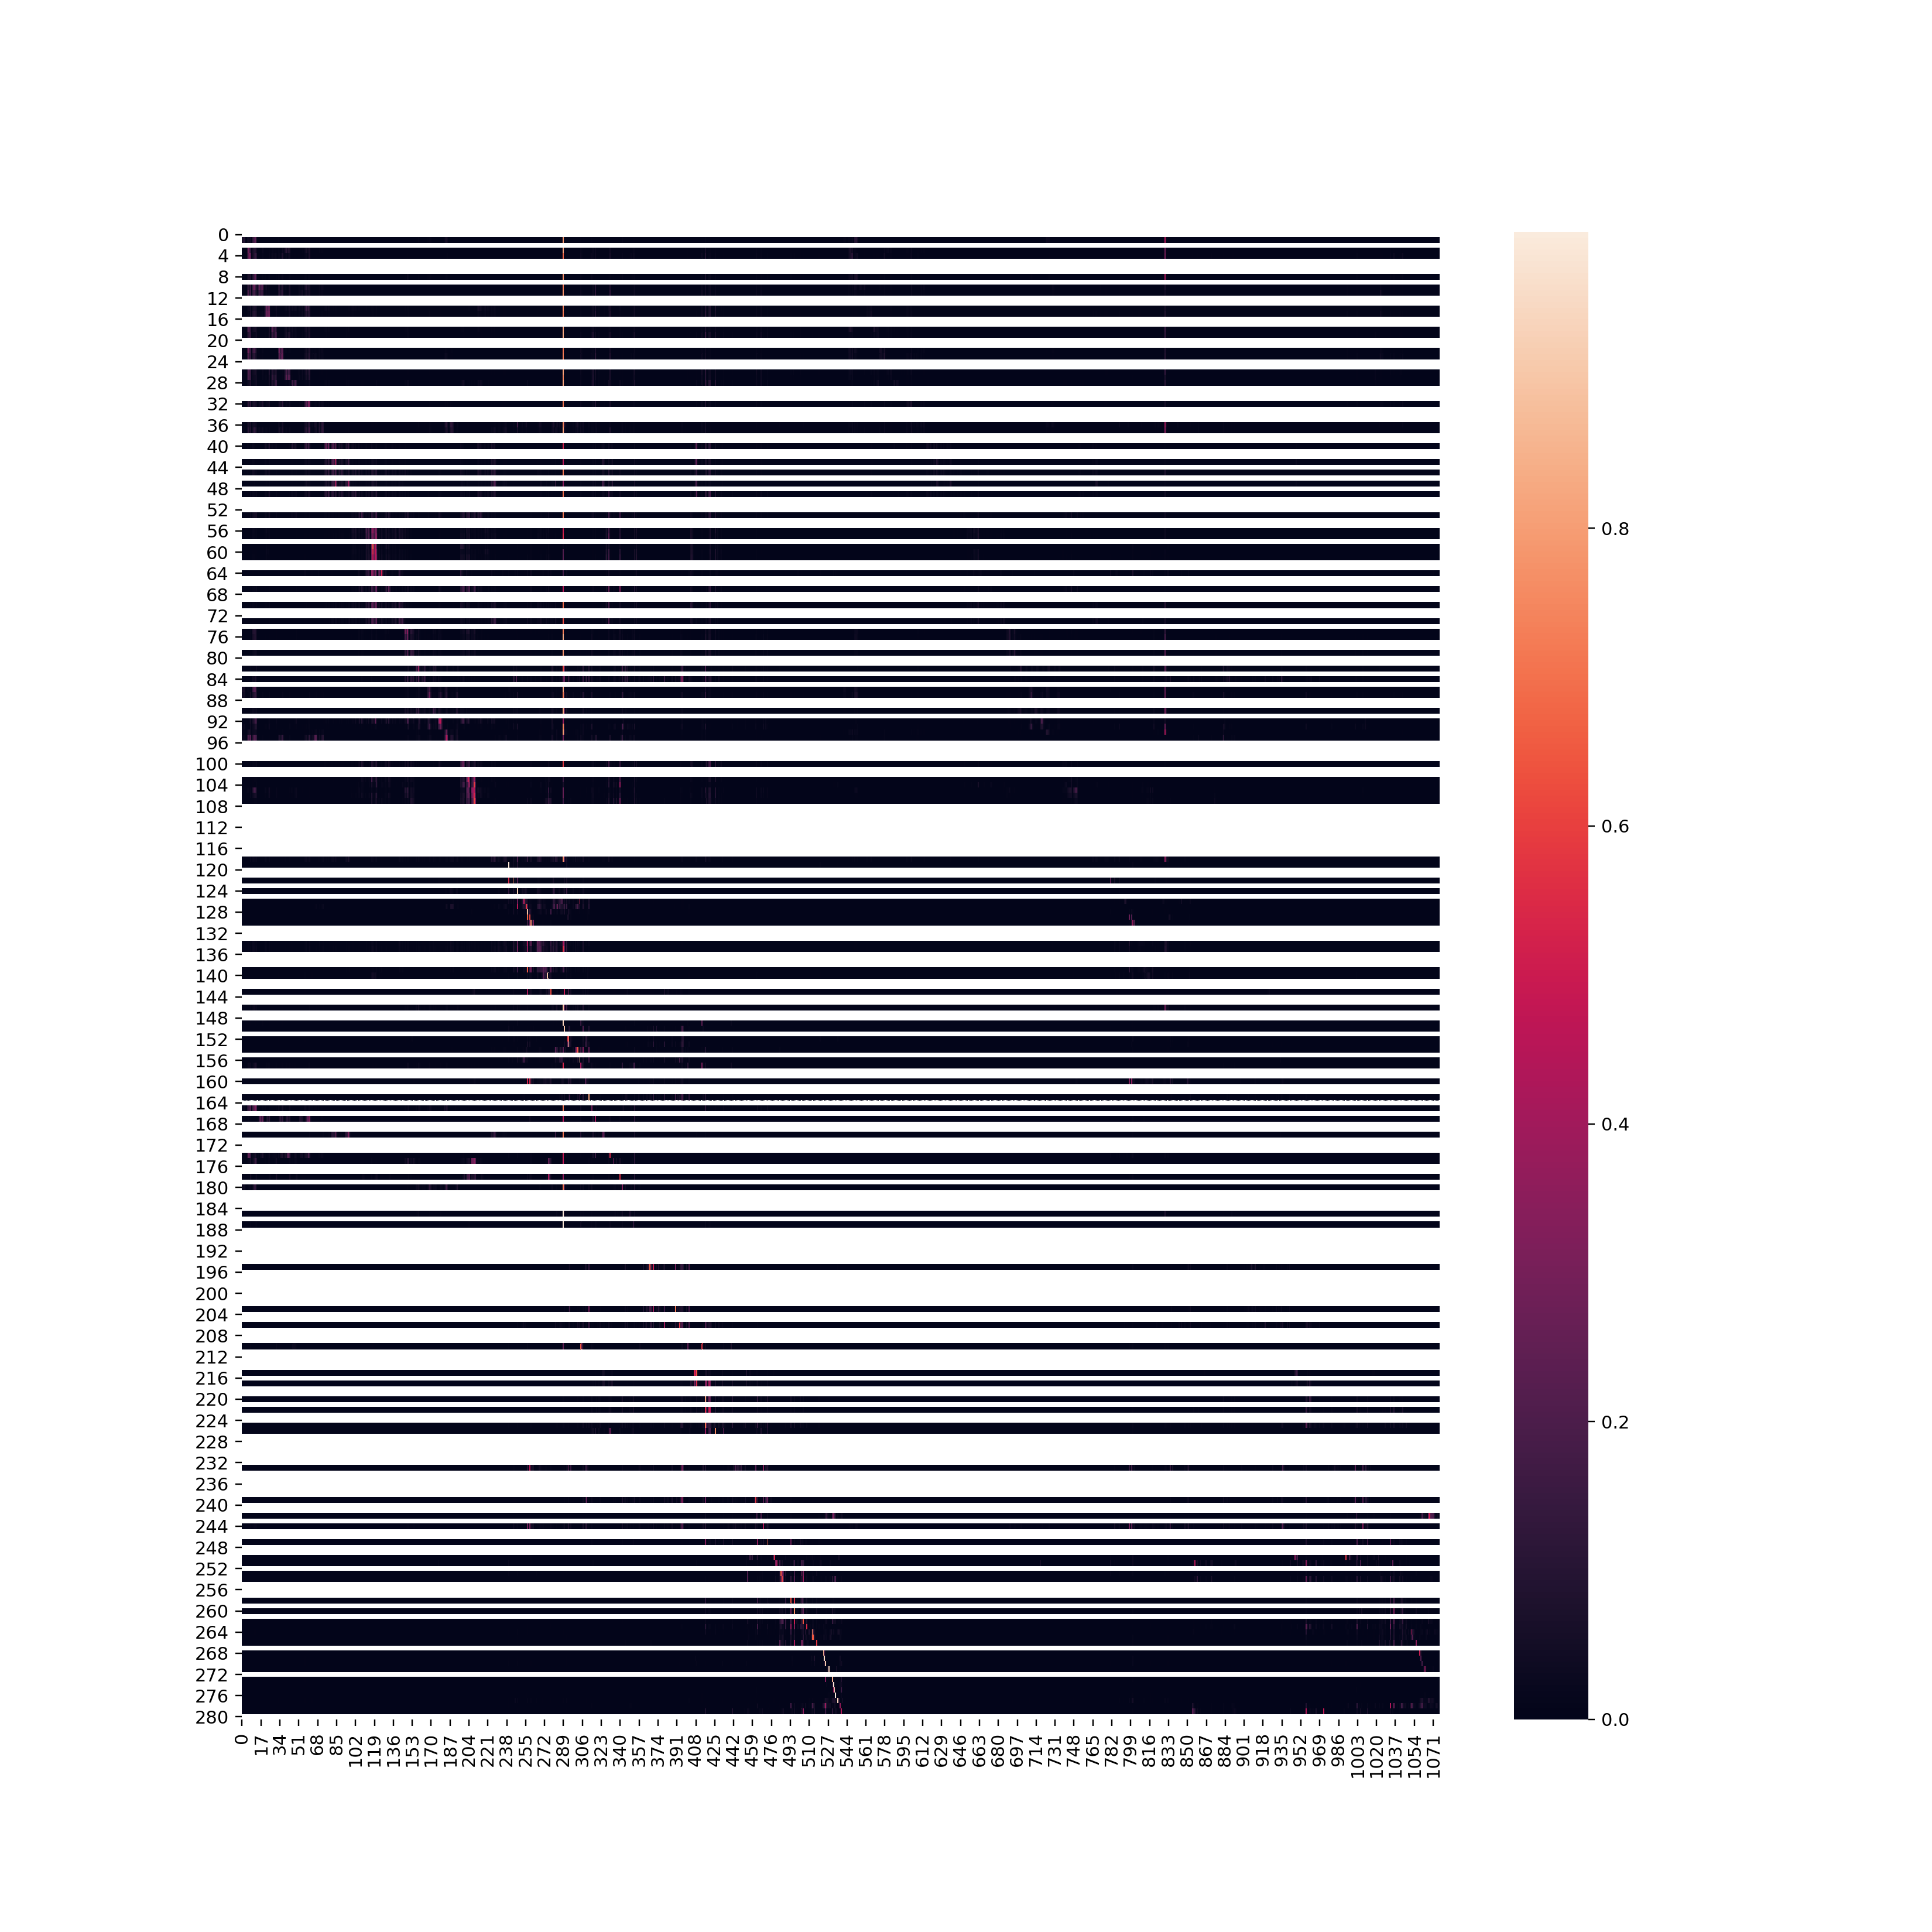

In [57]:
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(connectivity_matrices[0])

In [127]:
list_2 = contra_target_regions
list_1 = ontological_order_leaves
set_2 = frozenset(list_2)
contra_reorder = [x for x in list_1 if x in set_2]
col_ids = np.concatenate([ontological_order_leaves,contra_reorder])
col_names = np.asarray([ia_map[col_ids[i]] for i in range(len(col_ids))])



for i in range(536):
    col_names[541:][i] = col_names[541:][i]+ '.1'


In [128]:
col_names

array(['FRP1', 'FRP2/3', 'FRP5', ..., 'FN.1', 'IP.1', 'DN.1'],
      dtype='<U10')

In [63]:
len(ontological_order_leaves)

541

In [126]:
1077 - 541

536

In [64]:
wt_conn_old = pd.read_csv('/Users/samsonkoelle/wt_conn2', index_col=0)

In [129]:
wt_conn = pd.DataFrame(connectivity_matrices[0], index= wt_conn_old.index, columns = col_names)

In [130]:
wt_conn.to_csv('/Users/samsonkoelle/wt_conn_leaf.csv')

In [131]:
wt_conn.shape

(281, 1077)

In [134]:
np.asarray(wt_conn.columns[:1077])[:200]

array(['FRP1', 'FRP2/3', 'FRP5', 'FRP6a', 'FRP6b', 'MOp1', 'MOp2/3',
       'MOp5', 'MOp6a', 'MOp6b', 'MOs1', 'MOs2/3', 'MOs5', 'MOs6a',
       'MOs6b', 'SSp-n1', 'SSp-n2/3', 'SSp-n4', 'SSp-n5', 'SSp-n6a',
       'SSp-n6b', 'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5',
       'SSp-bfd6a', 'SSp-bfd6b', 'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4',
       'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b', 'SSp-m1', 'SSp-m2/3', 'SSp-m4',
       'SSp-m5', 'SSp-m6a', 'SSp-m6b', 'SSp-ul1', 'SSp-ul2/3', 'SSp-ul4',
       'SSp-ul5', 'SSp-ul6a', 'SSp-ul6b', 'SSp-tr1', 'SSp-tr2/3',
       'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b', 'SSp-un1',
       'SSp-un2/3', 'SSp-un4', 'SSp-un5', 'SSp-un6a', 'SSp-un6b', 'SSs1',
       'SSs2/3', 'SSs4', 'SSs5', 'SSs6a', 'SSs6b', 'GU1', 'GU2/3', 'GU4',
       'GU5', 'GU6a', 'GU6b', 'VISC1', 'VISC2/3', 'VISC4', 'VISC5',
       'VISC6a', 'VISC6b', 'AUDd1', 'AUDd2/3', 'AUDd4', 'AUDd5', 'AUDd6a',
       'AUDd6b', 'AUDp1', 'AUDp2/3', 'AUDp4', 'AUDp5', 'AUDp6a', 'AUDp6b',
       'AUDpo1

In [125]:
len(wt_conn.index)

281

In [135]:
inc_row = np.asarray(['VISal4', 'VISal5',
       'VISal6a', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISl2/3',
       'VISl4', 'VISl5', 'VISl6a', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a',
       'VISp6b', 'VISpm4', 'VISpm5', 'VISpm6a'])
inc_col = np.asarray(['VISal1',
       'VISal2/3', 'VISal4', 'VISal5', 'VISal6a', 'VISal6b', 'VISam1',
       'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b', 'VISl1',
       'VISl2/3', 'VISl4', 'VISl5', 'VISl6a', 'VISl6b', 'VISp1',
       'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',  'VISpm1',
       'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b'])

In [140]:
wt_visual_subset = wt_conn.loc[['VISal5','VISam5','VISl4','VISl5','VISp2/3','VISp4','VISp5','VISpm5'],inc_col]

In [141]:
wt_visual_subset.to_csv('/Users/samsonkoelle/wt_visual_subset.csv')

In [ ]:
wt_visual_subset.

In [ ]:
#names: V1 -> VISp

#LM -> VISl

#?? RL -> VISrl

#AL -> VISal

#PM -> VISpm

#AM -> VISam



#included?
#'VISli4', 'VISli5', 'VISli6a', 

In [113]:
hjkl = np.asarray(list(wt_conn.columns))

In [114]:
hjkl.sort()

In [117]:
hjkl[:1000]

array(['AAA', 'AAA.1', 'ACAd1', 'ACAd1', 'ACAd2/3', 'ACAd2/3', 'ACAd5',
       'ACAd5', 'ACAd6a', 'ACAd6a', 'ACAd6b', 'ACAd6b', 'ACAv1', 'ACAv1',
       'ACAv2/3', 'ACAv2/3', 'ACAv5', 'ACAv5', 'ACAv6a', 'ACAv6a',
       'ACAv6b', 'ACAv6b', 'ACB', 'ACB', 'ACVII', 'ACVII.1', 'AD', 'AD.1',
       'ADP', 'ADP.1', 'AHN', 'AHN.1', 'AId1', 'AId1', 'AId2/3', 'AId2/3',
       'AId5', 'AId5', 'AId6a', 'AId6a', 'AId6b', 'AId6b', 'AIp1', 'AIp1',
       'AIp2/3', 'AIp2/3', 'AIp5', 'AIp5', 'AIp6a', 'AIp6a', 'AIp6b',
       'AIp6b', 'AIv1', 'AIv1', 'AIv2/3', 'AIv2/3', 'AIv5', 'AIv5',
       'AIv6a', 'AIv6a', 'AIv6b', 'AIv6b', 'AMBd', 'AMBd.1', 'AMBv',
       'AMBv.1', 'AMd', 'AMd.1', 'AMv', 'AMv.1', 'ANcr1', 'ANcr1.1',
       'ANcr2', 'ANcr2.1', 'AOBgl', 'AOBgl', 'AOBgr', 'AOBgr', 'AOBmi',
       'AOBmi', 'AON', 'AON', 'AP', 'AP.1', 'APN', 'APN.1', 'ARH',
       'ARH.1', 'ASO', 'ASO.1', 'AT', 'AT.1', 'AUDd1', 'AUDd1', 'AUDd2/3',
       'AUDd2/3', 'AUDd4', 'AUDd4', 'AUDd5', 'AUDd5', 'AUDd6a', 'AUDd6a'

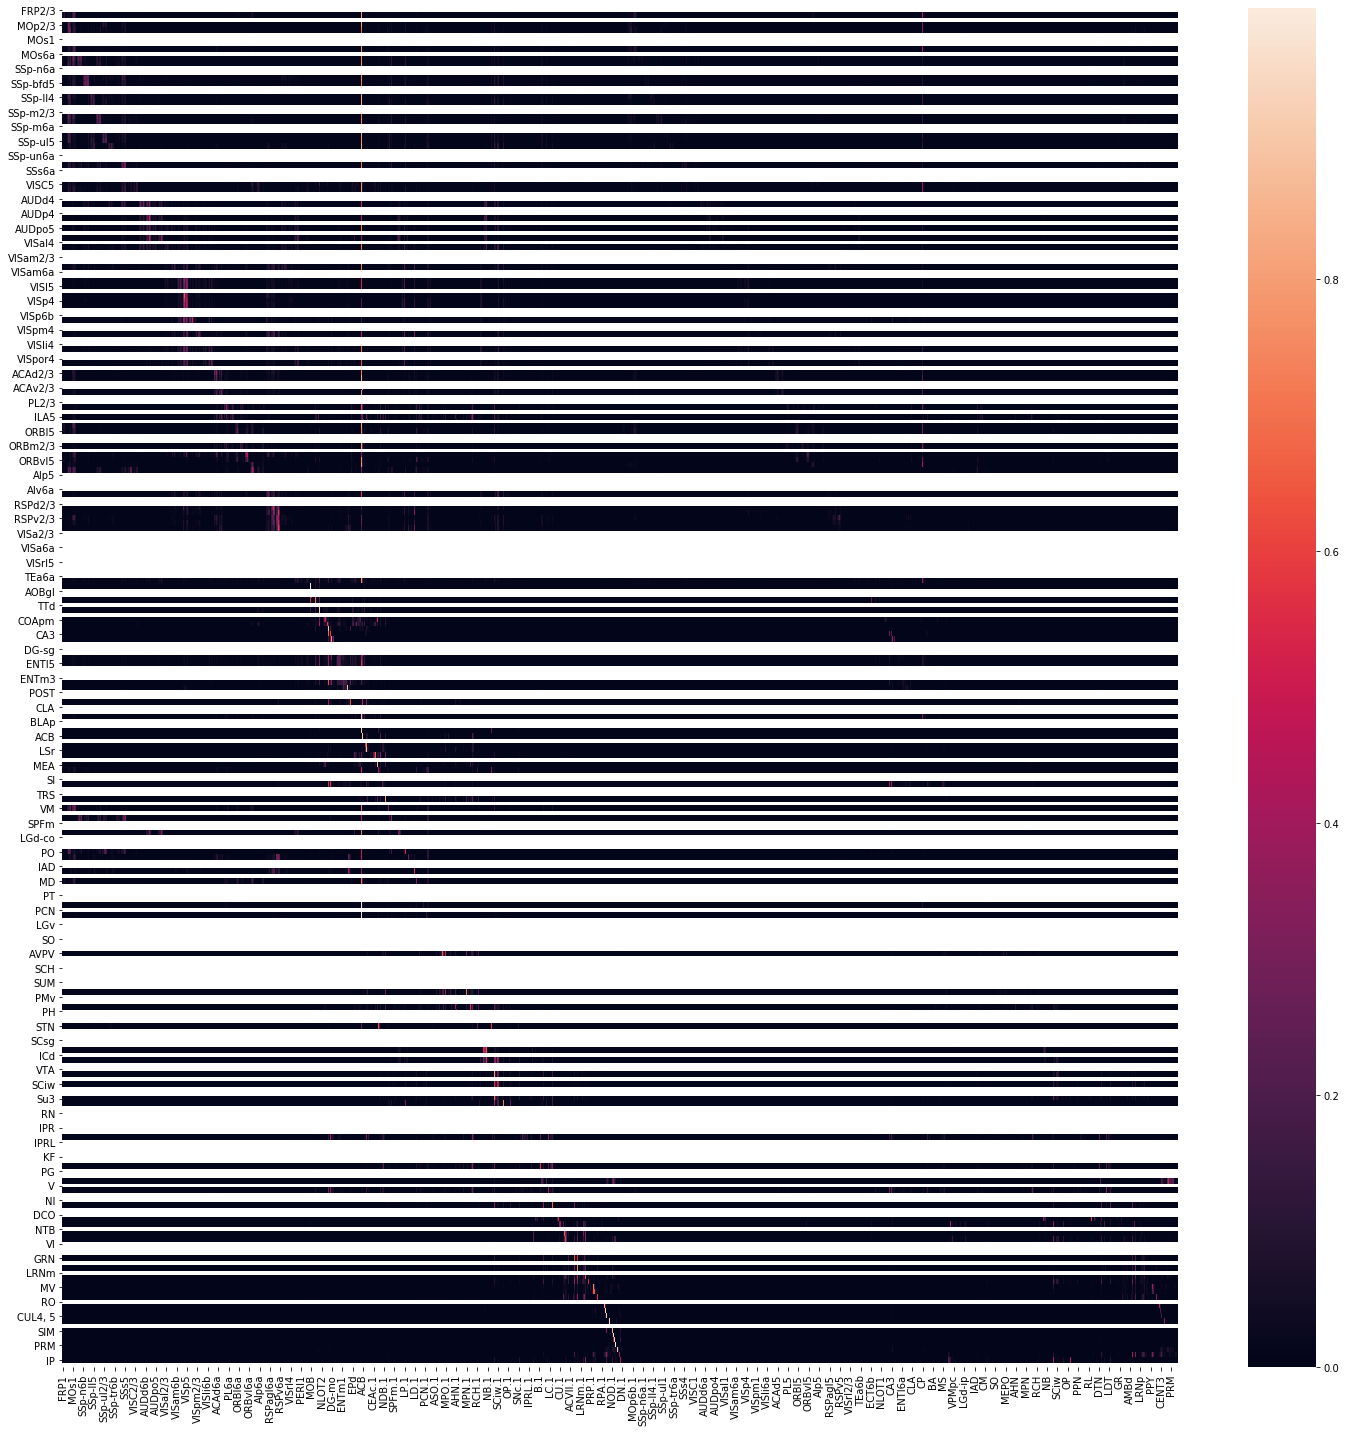

In [72]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (25,25))
sns.heatmap(wt_conn)

In [ ]:
#5 layers (1, 2/3, 4, 5, 6) within a visual area (V1, LM, RL, AL, PM, AM)

In [76]:
asdf = np.asarray(wt_conn.columns.copy())

In [77]:
asdf.sort()

In [87]:
asdf[:1000]

array(['AAA', 'AAA.1', 'ACAd1', 'ACAd1', 'ACAd2/3', 'ACAd2/3', 'ACAd5',
       'ACAd5', 'ACAd6a', 'ACAd6a', 'ACAd6b', 'ACAd6b', 'ACAv1', 'ACAv1',
       'ACAv2/3', 'ACAv2/3', 'ACAv5', 'ACAv5', 'ACAv6a', 'ACAv6a',
       'ACAv6b', 'ACAv6b', 'ACB', 'ACB', 'ACVII', 'ACVII.1', 'AD', 'AD.1',
       'ADP', 'ADP.1', 'AHN', 'AHN.1', 'AId1', 'AId1', 'AId2/3', 'AId2/3',
       'AId5', 'AId5', 'AId6a', 'AId6a', 'AId6b', 'AId6b', 'AIp1', 'AIp1',
       'AIp2/3', 'AIp2/3', 'AIp5', 'AIp5', 'AIp6a', 'AIp6a', 'AIp6b',
       'AIp6b', 'AIv1', 'AIv1', 'AIv2/3', 'AIv2/3', 'AIv5', 'AIv5',
       'AIv6a', 'AIv6a', 'AIv6b', 'AIv6b', 'AMBd', 'AMBd.1', 'AMBv',
       'AMBv.1', 'AMd', 'AMd.1', 'AMv', 'AMv.1', 'ANcr1', 'ANcr1.1',
       'ANcr2', 'ANcr2.1', 'AOBgl', 'AOBgl', 'AOBgr', 'AOBgr', 'AOBmi',
       'AOBmi', 'AON', 'AON', 'AP', 'AP.1', 'APN', 'APN.1', 'ARH',
       'ARH.1', 'ASO', 'ASO.1', 'AT', 'AT.1', 'AUDd1', 'AUDd1', 'AUDd2/3',
       'AUDd2/3', 'AUDd4', 'AUDd4', 'AUDd5', 'AUDd5', 'AUDd6a', 'AUDd6a'

In [89]:
ia_map['RL.1']

KeyError: 'RL.1'

In [92]:
st.child_ids([ai_map['RL']]

[[]]

In [83]:
mmmm = np.asarray(list(ai_map.keys()))

In [84]:
mmmm.sort()

In [86]:
mmmm[:100]

array(['6b', 'A13', 'AAA', 'ACA', 'ACA1', 'ACA2/3', 'ACA5', 'ACA6a',
       'ACA6b', 'ACAd', 'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
       'ACAv', 'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b', 'ACB',
       'ACVI', 'ACVII', 'AD', 'ADP', 'AHA', 'AHN', 'AHNa', 'AHNc', 'AHNd',
       'AHNp', 'AI', 'AId', 'AId1', 'AId2/3', 'AId5', 'AId6a', 'AId6b',
       'AIp', 'AIp1', 'AIp2/3', 'AIp5', 'AIp6a', 'AIp6b', 'AIv', 'AIv1',
       'AIv2/3', 'AIv5', 'AIv6a', 'AIv6b', 'AM', 'AMB', 'AMBd', 'AMBv',
       'AMd', 'AMv', 'AN', 'ANcr1', 'ANcr1gr', 'ANcr1mo', 'ANcr1pu',
       'ANcr2', 'ANcr2gr', 'ANcr2mo', 'ANcr2pu', 'AOB', 'AOBgl', 'AOBgr',
       'AOBmi', 'AON', 'AON1', 'AON2', 'AONd', 'AONe', 'AONl', 'AONm',
       'AONpv', 'AP', 'APN', 'APr', 'AQ', 'ARH', 'ASO', 'AT', 'ATN',
       'AUD', 'AUDd', 'AUDd1', 'AUDd2/3', 'AUDd4', 'AUDd5', 'AUDd6a',
       'AUDd6b', 'AUDp', 'AUDp1', 'AUDp2/3', 'AUDp4', 'AUDp5', 'AUDp6a'],
      dtype='<U12')

In [31]:
meanloss_nw_leaf_leaf2_2stage

array([0.03991072, 0.60140432, 0.08764683, 0.20692969, 0.16090764,
       0.144303  , 0.15729665, 0.0529763 , 0.2574036 , 0.14085968,
       0.04951165, 0.29644311])

In [ ]:
meanloss_nw_leaf_leaf2wt

In [15]:
connectivity_data.structure_datas[sid].reg_proj_vcount_norm.shape

(36, 1077)

In [6]:
sid = 512
eid = list(connectivity_data.structure_datas[sid].experiment_datas.keys())[0]
connectivity_data.structure_datas[sid].experiment_datas[eid].injection_qmasked

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [7]:
default_structure_ids

[315, 698, 1089, 703, 477, 803, 549, 1097, 313, 771, 354, 512]

In [ ]:
connectivity_data.get_crelines(data_info)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs

In [93]:
manifest_file

'/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/new_manifest.json'

In [ ]:
cache = VoxelModelCache(manifest_file=manifest_file)

In [ ]:
687527945

In [97]:
#COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS2 = tuple([167587189])
tree2 = cache.get_structure_tree()
default_structures2 = tree2.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS2)
default_structure_ids2 = [st['id'] for st in default_structures2 if st['id'] != 934]


In [96]:
len(default_structure_ids2)

292

In [99]:
ai_map default_structure_ids2)

316

In [103]:
len(list(ia_map.keys()))

1327

In [105]:
xxxx = np.asarray(list(ai_map.keys()))

In [106]:
xxxx.sort()

In [108]:
xxxx[:100]

array(['6b', 'A13', 'AAA', 'ACA', 'ACA1', 'ACA2/3', 'ACA5', 'ACA6a',
       'ACA6b', 'ACAd', 'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
       'ACAv', 'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b', 'ACB',
       'ACVI', 'ACVII', 'AD', 'ADP', 'AHA', 'AHN', 'AHNa', 'AHNc', 'AHNd',
       'AHNp', 'AI', 'AId', 'AId1', 'AId2/3', 'AId5', 'AId6a', 'AId6b',
       'AIp', 'AIp1', 'AIp2/3', 'AIp5', 'AIp6a', 'AIp6b', 'AIv', 'AIv1',
       'AIv2/3', 'AIv5', 'AIv6a', 'AIv6b', 'AM', 'AMB', 'AMBd', 'AMBv',
       'AMd', 'AMv', 'AN', 'ANcr1', 'ANcr1gr', 'ANcr1mo', 'ANcr1pu',
       'ANcr2', 'ANcr2gr', 'ANcr2mo', 'ANcr2pu', 'AOB', 'AOBgl', 'AOBgr',
       'AOBmi', 'AON', 'AON1', 'AON2', 'AONd', 'AONe', 'AONl', 'AONm',
       'AONpv', 'AP', 'APN', 'APr', 'AQ', 'ARH', 'ASO', 'AT', 'ATN',
       'AUD', 'AUDd', 'AUDd1', 'AUDd2/3', 'AUDd4', 'AUDd5', 'AUDd6a',
       'AUDd6b', 'AUDp', 'AUDp1', 'AUDp2/3', 'AUDp4', 'AUDp5', 'AUDp6a'],
      dtype='<U12')

In [ ]:
ia_map[default_structure_ids2[i]] for i in range()